# Micro-Doppler Effect of a Rotating Object with a Doppler Radar

This is an example of using `RadarSimPy` to simulate the micro-Doppler effect of a rotating turbine with
a Doppler radar. Ray-Tracing/Shoot-and-Bounce-Rays method is used in `RadarSimPy`. The ray-tracing engine `RadarSimC`, which is built with C++, is integrated in RadarSimPy.

>`RadarSimPy` is a radar simulation package built with python. **<a href="https://zpeng.me/#contact" target="_blank">Contact me</a> if you are interested in this module.**

This notebook is available on my <a href="https://github.com/rookiepeng/radar-simulation-notebooks" target="_blank">GitHub</a>.

---

## Radar Model
### Transmitter

The following table lists the basic parameters of the radar transmitter.

| Parameter                       | Variable in `RadarSimPy` | Value      |
|---------------------------------|--------------------------|------------|
| Center frequency ($f_c$)        | fc                       | 24.125 GHz |
| Transmitted power ($P_t$)       | tx_power                 | 10 dBm     |
| Signal length ($T$)             | pulse_length             | 2 s        |

### Receiver
The parameters of the receiver are listed in the table below.

| Parameter                        | Variable in `RadarSimPy` | Value        |
|----------------------------------|--------------------------|--------------|
| Sampling rate ($f_s$)            | fs                       | 400 sps      |
| Noise figure ($NF$)               | noise_figure              | 20 dB        |
| RF gain/loss ($G_{rf}$)          | rf_gain                  | 20 dB        |
| Baseband gain ($G_{BB}$)         | baseband_gain            | 50 dB        |
| Load resistor ($R_L$)            | load_resistor            | 1000 $\Omega$|

### Aperture
The radar aperture to receive the reflected rays. 

| Parameter   | Physical Meaning                                       |
|-------------|--------------------------------------------------------|
| phi         | Angle phi of the aperture normal (degree)              |
| theta       | Angle theta of the aperture normal (degree)            |
| location    | Center location of the aperture (x, y, z) m            |
| extension   | Extension of the aperture (left, right, top, bottom) m |


In [1]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

tx = Transmitter(f=24.125e9,
                 t=12,
                 tx_power=10,
                 pulses=1,
                 channels=[dict(location=(0, 0, 0))])

rx = Receiver(fs=400,
              noise_figure=12,
              rf_gain=20,
              baseband_gain=50,
              load_resistor=1000,
              channels=[dict(location=(0, 0, 0))])


radar = Radar(transmitter=tx, receiver=rx)

radar = Radar(transmitter=tx, receiver=rx)

## Target Model

Load the stl model of the target and set the `location`, `speed`, `rotation`, and `rotation_rate` of the target.

- `location`: (x, y, z) m
- `speed`: (x, y, z) m/s
- `rotation`: (yaw, pitch, roll) degree
- `rotation_rate`: (yaw, pitch, roll) degree/s

In this simulation, the target is a 3-blade turbine. The turbine is rotating along the y-axis with -20 degree/s.

In [2]:
# target_1 = {
#     'model': '../models/fan_3blade.stl',
#     'location': (30, 0, 0),
#     'rotation': (0, 0, 0),
#     'rotation_rate': (0, 10, 0),
#     'speed': (0, 0, 0)
# }

# targets = [target_1]

In [3]:
target_1 = {
    'model': '../models/fan_3blade.stl',
    'location': (30, 0, 0),
    'rotation': [0, 10*radar.timestamp, 0],
    'rotation_rate': (0, 0, 0),
    'speed': (0, 0, 0)
}

targets = [target_1]

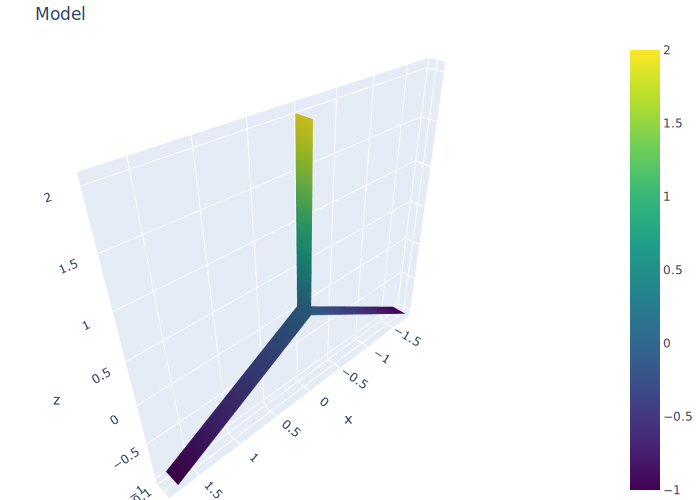

In [4]:
from stl import mesh
import plotly.graph_objs as go
from plotly.offline import iplot
from IPython.display import SVG, display

mesh_data = mesh.Mesh.from_file(target_1['model'])

x = np.ravel(mesh_data.vectors[:, :, 0])
y = np.ravel(mesh_data.vectors[:, :, 1])
z = np.ravel(mesh_data.vectors[:, :, 2])

plate = go.Mesh3d(x=x, y=y, z=z, opacity=1,
                  i=np.arange(0, np.shape(mesh_data.vectors)[0]*3, 3),
                  j=np.arange(1, np.shape(mesh_data.vectors)[0]*3, 3),
                  k=np.arange(2, np.shape(mesh_data.vectors)[0]*3, 3),
                  intensity=z, colorscale='Viridis'
                  )

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2.25, y=2.25, z=2.25)
)


layout = go.Layout(
    title='Model',
    scene=dict(
        aspectmode='data',
        camera=camera,
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig = go.Figure(data=[plate], layout=layout)
# iplot(fig)
display(SVG(fig.to_image(format='svg', scale=1)))

## Ray Tracing

Simulate rays. `level='sample'` defines ray tracing for each sample point.

In [ ]:
from radarsimpy.rt import scene
import time

tic = time.time()
data = scene(radar, targets,
             density=0.2, level='sample', noise=True)
baseband = data['baseband']
timestamp = data['timestamp']
toc = time.time()

print(toc-tic)

In [ ]:
beat_I = go.Scatter(
    x=timestamp[0, 0, :],
    y=np.real(baseband[0, 0, :]),
    name='I',
)
beat_Q = go.Scatter(
    x=timestamp[0, 0, :],
    y=np.imag(baseband[0, 0, :]),
    name='Q',
)

data = [beat_I, beat_Q]

layout = go.Layout(
    title='I/Q Baseband Signals',
    yaxis=dict(title='Amplitude (V)'),
    xaxis=dict(title='Time (s)'),
)

fig = go.Figure(data, layout=layout)
# iplot(fig)
display(SVG(fig.to_image(format='svg', scale=1)))

## Short-Time Fourier Transform

In [ ]:
from scipy.signal import stft

spec = stft(baseband[0, 0, :], fs=radar.receiver.fs,
            nperseg=64, noverlap=32, nfft=128, return_onesided=False)

In [ ]:
idx_neg = np.where(spec[0] < 0)
idx_pos = np.where(spec[0] >= 0)

dopp_ordered = spec[0][np.concatenate([idx_neg[0], idx_pos[0]])]

spec_shifted = spec[2][np.concatenate([idx_neg[0], idx_pos[0]]), :]

data = go.Heatmap(
    z=20*np.log10(np.abs(spec_shifted)),
    x=spec[1],
    y=dopp_ordered,
    hoverongaps=False,
    colorscale='Jet')

layout = go.Layout(
    yaxis=dict(title='Doppler (Hz)'),
    xaxis=dict(title='Time (s)'),
    margin=dict(l=0, r=0, b=0, t=20)
)

fig = go.Figure(data=data, layout=layout)
# iplot(fig)
display(SVG(fig.to_image(format='svg', scale=1)))